In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

In [2]:
model="default2017-noaffinity-nostratified"
prefix="nc"

In [3]:
df = pd.read_csv("annotated.csv")
df

,pocket,protein,ligand,rank,rmsd,obrmsd,flexobrmsd,fmaxrmsd,score,group,annotation
0,ABL1,1FPU,3QRK,0,1.12474,1.12474,0.75627,1.09286,-11.82862,1,1
1,ABL1,1FPU,3QRK,10,7.46179,7.46179,1.38199,2.77094,-11.55337,1,0
2,ABL1,1FPU,3QRK,11,8.08863,8.08863,1.44861,2.51482,-11.47044,1,0
3,ABL1,1FPU,3QRK,12,8.47072,8.47072,1.60736,2.34249,-11.35890,1,0
4,ABL1,1FPU,3QRK,13,8.45633,8.45633,1.61014,2.35856,-11.32845,1,0
...,...,...,...,...,...,...,...,...,...,...,...
165586,XIAP,5C84,4KMP,5,9.60539,9.60539,1.43189,2.28256,-7.57331,63,0
165587,XIAP,5C84,4KMP,6,8.41238,8.41238,1.30168,2.39061,-7.51172,63,0
165588,XIAP,5C84,4KMP,7,6.88340,6.88340,0.95547,1.40152,-7.40088,63,0
165589,XIAP,5C84,4KMP,8,5.19961,5.19961,2.08915,2.97329,-7.32203,63,0


In [4]:
score = pd.concat((
    pd.read_csv(f"../training/{model}/{prefix}test0.out", sep=" ", header=None),
    pd.read_csv(f"../training/{model}/{prefix}test1.out", sep=" ", header=None),
    pd.read_csv(f"../training/{model}/{prefix}test2.out", sep=" ", header=None),
))

score.drop(columns=[1,2,4,5,6,7], inplace=True)

In [5]:
score.rename(columns={0: "CNNscore", 3: "name"}, inplace=True)
score.dropna(inplace=True) # Last row contains NaN (it is  actually a comment)
score

,CNNscore,name
0,0.199301,carlos_cd/ABL1/PDB_Structures/1FPU_PRO_3QRK_LI...
1,0.000416,carlos_cd/ABL1/PDB_Structures/1FPU_PRO_3QRK_LI...
2,0.004442,carlos_cd/ABL1/PDB_Structures/1FPU_PRO_3QRK_LI...
3,0.016586,carlos_cd/ABL1/PDB_Structures/1FPU_PRO_3QRK_LI...
4,0.018938,carlos_cd/ABL1/PDB_Structures/1FPU_PRO_3QRK_LI...
...,...,...
55107,0.979171,carlos_cd/WEE1/PDB_Structures/5VD2_PRO_5VC5_LI...
55108,0.773612,carlos_cd/WEE1/PDB_Structures/5VD2_PRO_5VC5_LI...
55109,0.186618,carlos_cd/WEE1/PDB_Structures/5VD2_PRO_5VC5_LI...
55110,0.167543,carlos_cd/WEE1/PDB_Structures/5VD2_PRO_5VC5_LI...


In [6]:
def getid(row):
    namesplit = row["name"].split("/")

    pocket = namesplit[1]

    split = namesplit[-1].split("_")

    protein = split[0]
    ligand = split[2]


    rank = int(split[-1][1:].replace(".gninatypes", ""))

    return (pocket, protein, ligand, rank)

In [7]:
score[["pocket", "protein", "ligand", "rank"]] = score.apply(getid, axis=1, result_type="expand")

In [8]:
score.drop(columns="name", inplace=True)

In [9]:
df = df.merge(score, on=["pocket", "protein", "ligand", "rank"])

In [10]:
df

,pocket,protein,ligand,rank,rmsd,obrmsd,flexobrmsd,fmaxrmsd,score,group,annotation,CNNscore
0,ABL1,1FPU,3QRK,0,1.12474,1.12474,0.75627,1.09286,-11.82862,1,1,0.199301
1,ABL1,1FPU,3QRK,10,7.46179,7.46179,1.38199,2.77094,-11.55337,1,0,0.000416
2,ABL1,1FPU,3QRK,11,8.08863,8.08863,1.44861,2.51482,-11.47044,1,0,0.004442
3,ABL1,1FPU,3QRK,12,8.47072,8.47072,1.60736,2.34249,-11.35890,1,0,0.016586
4,ABL1,1FPU,3QRK,13,8.45633,8.45633,1.61014,2.35856,-11.32845,1,0,0.018938
...,...,...,...,...,...,...,...,...,...,...,...,...
165586,XIAP,5C84,4KMP,5,9.60539,9.60539,1.43189,2.28256,-7.57331,63,0,0.001710
165587,XIAP,5C84,4KMP,6,8.41238,8.41238,1.30168,2.39061,-7.51172,63,0,0.000020
165588,XIAP,5C84,4KMP,7,6.88340,6.88340,0.95547,1.40152,-7.40088,63,0,0.000318
165589,XIAP,5C84,4KMP,8,5.19961,5.19961,2.08915,2.97329,-7.32203,63,0,0.001888


In [11]:
def topN(df, nmax, by=["pocket"]):

    n_pockets = 0
    
    top_smina = [0] * nmax
    top_gnina = [0] * nmax
    top_best = [0] * nmax

    for _, group in df.groupby(by):
        n_smina = [0] * nmax
        n_gnina = [0] * nmax
        n_best = [0] * nmax

        n_targets = 0
        for _, tgroup in group.groupby("protein"):
            smina = tgroup.sort_values(by="score", ascending=True)
            gnina = tgroup.sort_values(by="CNNscore", ascending=False)
            best = tgroup.sort_values(by="rmsd", ascending=True)

            for n in range(1, nmax + 1):
                # At least one good pose amongst the top N
                if (smina["annotation"].iloc[:n] == 1).any():
                    n_smina[n-1] += 1

                if (gnina["annotation"].iloc[:n] == 1).any():
                    n_gnina[n-1] += 1
                
                if (best["annotation"].iloc[:n] == 1).any():
                    n_best[n-1] += 1

            n_targets += 1

        # Accumulate results for all targets
        for n in range(1, nmax + 1):
            top_smina[n-1] += n_smina[n-1] / n_targets * 100
            top_gnina[n-1] += n_gnina[n-1]  / n_targets * 100
            top_best[n-1] += n_best[n-1]  / n_targets * 100

        n_pockets += 1

    # One pocket has been removed from the training set
    # for lack of actives
    assert n_pockets == 91

    # Return TopN of targets, averaged per pocket
    top_smina_avg = np.array(top_smina) / n_pockets
    top_gnina_avg = np.array(top_gnina) / n_pockets
    top_best_avg =  np.array(top_best) / n_pockets
    return np.array([list(range(1,nmax+1)), top_smina_avg, top_gnina_avg, top_best_avg]).T

In [12]:
topN(df, 3)

array([[ 1.        , 31.73062529, 47.21072959, 92.92841515],
       [ 2.        , 41.02849337, 63.33237809, 92.92841515],
       [ 3.        , 47.04665164, 71.25530906, 92.92841515]])

In [13]:
def plot(top):
    plt.plot(top[:,0], top[:,1], "o-", label="smina")
    plt.plot(top[:,0], top[:,2], "o-", label="gnina")
    plt.plot(top[:,0], top[:,3], "o-", label="best")
    plt.legend()
    plt.xlabel("N")
    plt.ylabel("TopN (%)")
    plt.plot()
    

In [14]:
nmax = 10
top_crystal = topN(df, 10)
top_crystal

array([[ 1.        , 31.73062529, 47.21072959, 92.92841515],
       [ 2.        , 41.02849337, 63.33237809, 92.92841515],
       [ 3.        , 47.04665164, 71.25530906, 92.92841515],
       [ 4.        , 50.15676524, 76.02867061, 92.92841515],
       [ 5.        , 54.2308915 , 79.35460665, 92.92841515],
       [ 6.        , 57.1035487 , 81.84136006, 92.92841515],
       [ 7.        , 59.01067293, 83.49871393, 92.92841515],
       [ 8.        , 62.41255969, 85.17388642, 92.92841515],
       [ 9.        , 64.0082783 , 86.23932131, 92.92841515],
       [10.        , 65.50842747, 87.25550374, 92.92841515]])

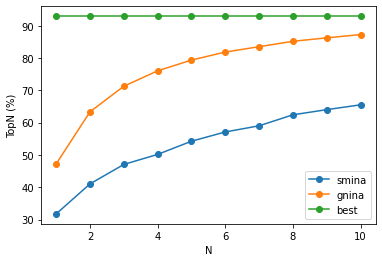

In [15]:
plot(top_crystal)

In [16]:
top_nocrystal = topN(df[df["rank"] != 0], nmax)
top_nocrystal

array([[ 1.        , 28.20117657, 30.97611966, 74.79001756],
       [ 2.        , 36.78287727, 41.41933408, 74.79001756],
       [ 3.        , 42.38098516, 47.36464724, 74.79001756],
       [ 4.        , 45.07630408, 52.40442903, 74.79001756],
       [ 5.        , 48.09237927, 55.8584943 , 74.79001756],
       [ 6.        , 50.26470662, 57.71540764, 74.79001756],
       [ 7.        , 51.82379024, 59.59059647, 74.79001756],
       [ 8.        , 53.40153423, 61.35277392, 74.79001756],
       [ 9.        , 54.55383463, 62.43435374, 74.79001756],
       [10.        , 55.81074578, 63.44927274, 74.79001756]])

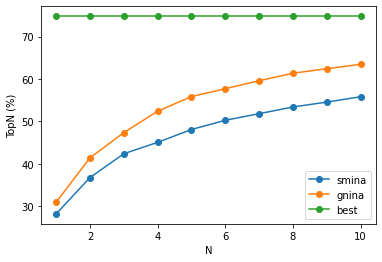

In [17]:
plot(top_nocrystal)